$\LaTeX$ macros
$\newcommand{\pba}{{p^b_a}}$
 $\newcommand{\dpba}{{\dot{p}^b_a}}$
 $\newcommand{\pag}{{p^a_g}}$
 $\newcommand{\pav}{{p^a_v}}$
 $\newcommand{\dpag}{{\dot{p}^a_g}}$
 $\newcommand{\pai}{{p^a_i}}$
 $\newcommand{\dpai}{{\dot{p}^a_i}}$
 $\newcommand{\pbg}{{p^b_g}}$
 $\newcommand{\dpbg}{{\dot{p}^b_g}}$
 $\newcommand{\ddpbg}{{\ddot{p}^b_g}}$
 $\newcommand{\pbi}{{p^b_i}}$
 $\newcommand{\dpbi}{{\dot{p}^b_i}}$
 $\newcommand{\ddpbi}{{\ddot{p}^b_i}}$
 $\newcommand{\Rba}{{R^b_a}}$
 $\newcommand{\dRba}{{\dot{R}{}^b_a}}$
 $\newcommand{\Rab}{{R^a_b}}$
 $\newcommand{\omaa}{{\omega^a_a}}$
 $\newcommand{\domaa}{{\dot{\omega}{}^a_a}}$
 $\newcommand{\Somaa}{{S\left(\omega^a_a\right)}}$
 $\newcommand{\dSomaa}{{S\left(\dot{\omega}{}^a_a\right)}}$
 $\newcommand{\Spag}{{S\left(p^a_g\right)}}$
 $\newcommand{\Spai}{{S\left(p^a_i\right)}}$
 $\newcommand{\nuaa}{{\nu^a_a}}$
 $\newcommand{\dnuaa}{{\dot{\nu}{}^a_a}}$
 $\newcommand{\Fb}{{F^b}}$
 $\newcommand{\Fa}{{F^a}}$
 $\newcommand{\Fg}{{F_g}}$
 $\newcommand{\Fv}{{F_v}}$
 $\newcommand{\Ng}{{N_g}}$
 $\newcommand{\Nv}{{N_v}}$
 $\newcommand{\Fe}{{F^{ext}}}$
 $\newcommand{\Na}{{N^a}}$
 $\newcommand{\BM}{\left[\begin{matrix}}$
 $\newcommand{\EBM}{\end{matrix}\right]}$
 $\newcommand{\gamaa}{{\gamma^a_a}}$
 $\newcommand{\dgamaa}{{\dot{\gamma}{}^a_a}}$
 $\newcommand{\vx}{\vec{x}}$
 $\newcommand{\vt}{\vec{\tau}}$
 $\newcommand{\vn}{\vec{\nu}}$
 $\newcommand{\T}{^\top}$

# Lab 02 - Simulation of flying robot

In this exercise simulation of a robot flying in 3 dimensions will be implemented.

## Equations of motion

The core of the simulation are the differential equations of motion:

$$
    \begin{align}
    \dpba &= \Rba \nuaa \\
    \dRba &= \Rba \Somaa \\
    \dgamaa &= M^{-1} \left(\Gamma - C \gamaa \right)
    \end{align}
$$

where:

$\pba$ - position vector of point $a$ in frame $b$

$\Rba$ - rotation of frame $a$ in frame $b$

$S(a) = \BM 0 & -a_z & a_y \\ a_z & 0 & -a_x \\ -a_y & a_x & 0 \EBM, \, a = \BM a_x \\ a_y \\ a_z \EBM$

$\nuaa = \BM u \\ v \\ w \EBM$ - vector of linear velocities of frame $a$ (in respect to inertial frame) expressed in frame $a$

$\omaa = \BM p \\ q \\ r \EBM$ - vector of angular velocities of frame $a$ (in respect to inertial frame) expressed in frame $a$

$\Fa$ - forces expressed in the local frame $a$

$\Na$ - torques expressed in the local frame $a$

$\pag$ - position of the center of mass in frame $a$

$m$ - mass of the simulated object

$I$ - inertia tensor of the simulated object

$$
 \begin{align}
  \gamaa \triangleq  \BM \nuaa \\ \omaa \EBM, \;
  \Gamma &\triangleq \BM \Fa \\ \Na \EBM
 \end{align}
 $$

 $$
 \begin{align}
   M &\triangleq \BM M_F \\ M_N \EBM = \BM m \cdot 1_{3\times 3} & -m \Spag \\  m \Spag & I \EBM\\
 C(\omaa) &\triangleq \BM C_F \\ C_N \EBM = \BM m \Somaa & - m \Somaa \Spag \\ m \Spag \Somaa & - \Somaa I \EBM\\
 \end{align}
 $$

## Helpful tools
In the proces of verification of any control algorithm it is imortant to measure and analyze results of simulations and experiments. In the experiments the problem is often difficult because of the measurement equipment errors and sometimes lack of possibility to measure some values. In the simmulations it is importent to implement mechanisms for logging all the nesseccary values, and methods to automaticly analyze them.

Below it there is simple example of logging function: ```log_results``` which use decorator pattern (https://www.python.org/dev/peps/pep-0318/). At the begging of this exercise it is important to get familiar with this function. What is worth noting, numerical solvers of differential equations sometimes recalculate results, because of that, in ```log_results``` simple method of data update is implemented. The consequance of that is the neccessity of adding time variable to the input of any decorated function, even if it is not used in the calculations performed by the function..

## Initialization of the environment

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import doctest

MAT = np.array
S = lambda a: MAT([[0, -a[2][0], a[1][0]],[a[2][0], 0, -a[0][0]],[-a[1][0], a[0][0], 0]]) # skew-symmetric matrix

## Exercise 1:
Analyse the body of the function ```log_results```, test and **understand** its behavior.

In [2]:
import functools

def log_results(func):
    @functools.wraps(func)
    def w_dec(*args, **kwargs):
        res = func(*args, **kwargs)
        t_old = -1 if len(w_dec.t) == 0 else w_dec.t[-1]
        t_new = args[0]
        if t_new > t_old:
            w_dec.log.append(res)
            w_dec.t.append(args[0])
        else:
            f = filter(lambda x: x >= t_new, w_dec.t)
            idx = w_dec.t.index(next(f))
            w_dec.log = w_dec.log[0:idx]+[res]
            w_dec.t = w_dec.t[0:idx]+[t_new]
        return res
    w_dec.log = []
    w_dec.t = []
    return w_dec

Execute funtion ```decorator_test``` a few times and print it results to verify your understanding of it.

In [3]:
@log_results
def decorator_test(t,x):
    return MAT([x ** 2, x * 2])

# write your code here
t = 1
decorator_test(t, 3)
print(decorator_test.log)
print(decorator_test.t)
# write your code here
t = 2
decorator_test(t, 3)
print(decorator_test.log)
print(decorator_test.t)
# write your code here
t = 3
decorator_test(0, 3)
decorator_test(1, 3)
decorator_test(2, 3)
decorator_test(1, 3)
print(decorator_test.log)
print(decorator_test.t)
# write your code here
t = 1
decorator_test(t, 3)
print(decorator_test.log)
print(decorator_test.t)

[array([9, 6])]
[1]
[array([9, 6]), array([9, 6])]
[1, 2]
[array([9, 6]), array([9, 6])]
[0, 1]
[array([9, 6]), array([9, 6])]
[0, 1]


## Exercise 2:
Define all constant parameters:
- standard acceleration due to gravity: $g = 9.81 \frac{m}{s^2}$
- density of air: $\rho_{air} = 1.225 \frac{kg}{m^3}$
- mass of the simulated robot: $m = 10 kg$
- volume of the simulated robot: $V = 0.01 m^3$
- inertia tensor in the local frame: $I = \BM 1 & 0 & 0 \\ 0 & 1 & 0 \\0 & 0 & 1\\ \EBM$
- matrix of aerodynamical coefficients: $C_a = \BM -5 & 0 & 0 & 0 & 0 & 0\\ 
                                                   0 & -5 & 0 & 0 & 0 & 0\\ 
                                                   0 & 0 & -5 & 0 & 0 & 0\\ 
                                                   0 & 0 & 0 & -5 & 0 & 0\\ 
                                                   0 & 0 & 0 & 0 & -5 & 0\\ 
                                                   0 & 0 & 0 & 0 & 0 & -5\\ \EBM$


**Assumption**: center of gravity, center of volume and origin of the local frame coincide.

Taking into account above assumption define also mass matrix (and its inversion) and function calculating matrix of Coriolis and centrifugal forces.

It can be helpful to use functions ```eye```, ```concatenate``` and ```linalg.inv``` from ```numpy``` library.

In [4]:
## write your code here
# standard acceleration
G = 9.81
# density of air
rho_air = 1.225
# mass
m = 10
# volume
V = 0.01
# inertia tensor
I = MAT([[1, 0, 0],[0,1,0],[0,0,1]])
# matrix of aerodynamical coefficients
Ca = np.zeros((6,6), int)
np.fill_diagonal(Ca, -5)
# position of the center of gravity in the local frame
pag = MAT([0,0,0])
# position of the center of volume in the local frame
pav = MAT([0,0,0])
# mass matrix and its inversion
S = np.zeros((3,3), int)
MF =np.concatenate((m*I, -m*S), 1)
MN = np.concatenate((m*S, I),1)
M = np.concatenate((MF, MN), 0)
iM = np.linalg.inv(M) 
# matrix of Coriolis and centrifugal forces
@log_results
def C(t,gamma):
    
  #  Coriolis and centrifugal forces

    
  
    omaa = gamma[3:6]
    ## write your code here
    Som = MAT([[0, -omaa[2], omaa[1]], [omaa[2], 0, -omaa[0]], [-omaa[1], omaa[0], 0]])
    #print(Som)
    CF = np.concatenate((m*Som, -m*Som*S), 1)
    CN = np.concatenate((m*S*Som, -Som*I), 1)
    C = np.concatenate((CF, CN), 0)
    return C
########################
gamma = MAT([[1,2,3,4,5,6]]).T
#C(0,gamma).shape(6, 6)
print(C(1, gamma))
doctest.testmod()

[[0 array([-60]) array([50]) 0 array([0]) array([0])]
 [array([60]) 0 array([-40]) array([0]) 0 array([0])]
 [array([-50]) array([40]) 0 array([0]) array([0]) 0]
 [0 array([0]) array([0]) 0 array([0]) array([0])]
 [array([0]) 0 array([0]) array([0]) 0 array([0])]
 [array([0]) array([0]) 0 array([0]) array([0]) 0]]


TestResults(failed=0, attempted=0)

## Exercise 3:
Let define variables:
- vector of desired state and velocities: $\xi_d = \BM \pba_d & \vec{\Rba_d} & \gamaa_d \EBM\T$, where $\vec{\Rba_d}$ is $\Rba_d$ reshaped into dimension $9 \times 1$. It is neccessary for the implementation.
- vector of states, velocities and integral of errors:
$xi=\BM \pba & \vec{\Rba} & \gamaa & \epsilon_i \EBM\T$, where $\vec{\Rba}$ is $\Rba$ reshaped into dimension $9 \times 1$ and
$$
\begin{align}
\epsilon_i = \int \left(\xi_d - \BM \pba \\ \vec{\Rba} \\ \gamaa \EBM\right) dt
\end{align}
$$
variable $\epsilon_i$ is introduced to help with implementation of integral controller.

Next, let implement basic controller functions:

In [131]:
@log_results
def controller(t, xi, xid):
    """
    Controller function.

    >>> xi = np.zeros((36,1))
    >>> xid = np.zeros((18,1)); 
    >>> controller(0,xi,xid).shape
    (6, 1)
    """
    # x, y, z, R11,R12,R13,R21,R22,R23,R31,R32,R33, u, v, w, p, q, r = xi
    x, y, z, R11,R12,R13,R21,R22,R23,R31,R32,R33, u, v, w, p, q, r = xi[0:18]
    iex, iey, iez, ieR11,ieR12,ieR13,ieR21,ieR22,ieR23,ieR31,ieR32,ieR33, ieu, iev, iew, iep, ieq, ier  = xi[18:36]
    pba = MAT([x,y,z])
    Rba = MAT([R11,R12,R13,R21,R22,R23,R31,R32,R33]).reshape(3,3)
    gamma = MAT([u,v,w,p,q,r])
    vaa = MAT([u,v,w])
    omaa = MAT([p,q,r])

    xd, yd, zd, R11d,R12d,R13d,R21d,R22d,R23d,R31d,R32d,R33d, ud, vd, wd, pd, qd, rd = xid
    pbad = MAT([xd,yd,zd])
    Rbad = MAT([R11d,R12d,R13d,R21d,R22d,R23d,R31d,R32d,R33d]).reshape(3,3)
    gammad = MAT([ud,vd,wd,pd,qd,rd])
    vaad = MAT([ud,vd,wd])
    omaad = MAT([pd,qd,rd])

    tauu = 0
    tauv = 0
    tauw = 0
    taup = 0
    tauq = 0
    taur = 0

    
    tau = MAT([[tauu,tauv,tauw,taup,tauq,taur]]).T
    return tau

doctest.testmod()    

TestResults(failed=0, attempted=6)

Trajectory generator function can be tested independen, because of that change below basic trajectory generator to create positional trajectory in the form of helix of given radius, and velocity of ascenndence. Than implement basic visualisation of generated trajectory in 3 dimensional space (https://matplotlib.org/tutorials/toolkits/mplot3d.html).

(100,)


TestResults(failed=0, attempted=6)

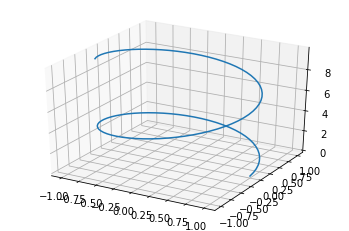

In [52]:
@log_results
def trajectory(t):    
    """
    Trajectory generator function.
    pbad - desired position vector
    Rbad - desired orientation (in the form of the rotation matrix)
    gammad - desired velocieties

    >>> trajectory(0).shape
    (18, 1)
    """
    xd = np.cos(t)
    yd = np.sin(t)
    zd = t
    Rbad = MAT([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ])
    ud = 0
    vd = 0
    wd = 0
    pd = 0
    qd = 0
    rd = 0
    
    pbad = MAT([[xd,yd,zd]]).T
    vRbad = Rbad.reshape(9, 1)
    gammad = MAT([[ud,vd,wd,pd,qd,rd]]).T
    xid = np.concatenate([pbad,vRbad,gammad])
    return xid

for i in range(0,100,1):
    t = i*0.1
    trajectory(t)

print(MAT(trajectory.log).T[0][0].shape)
xid = MAT(trajectory.log).T[0]

# visualisation
## write your code here
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xid[0],xid[1],xid[2])


######################
doctest.testmod()    

## Exercise 4:
In this exercise, the influence of the environment on the robot will be implemented. Remembering about the following dependencies, complete the ```external_forces``` function in such a way that the output of the function contains the vector of all external forces (excluding the $\tau$). **Remember about differences between base/global and local frames.**

Gravity:
 $$
    \begin{align}
    \Fg^b =& \BM 0 \\ 0 \\ -m \cdot g \EBM \\
    \Ng^a =& S(\pag)\Fg^a
    \end{align}
 $$
 
 Buoyancy:
 $$
 \begin{align}
    \Fv^b =& \BM 0 \\ 0 \\ \rho_{air} \cdot g \cdot V \EBM \\
    \Nv^a =& S(\pav)\Fv^a
 \end{align}
$$

Aerodynamical forces:
$$
\begin{align}
   \gamma^a_{aw} =& \gamma^a_a - \gamma^a_w \\
   \Gamma_{aw} =& C_a \cdot \text{sign}\left(\gamma^a_{aw}\right) \circ \gamma^a_{aw} \circ \gamma^a_{aw}
\end{align}
$$

Assume constant wind.

In [142]:
# vector of wind velocities expressed in global frame
gammab_wind = MAT([[0,1,0,0,0,0]]).T

@log_results
def external_forces(t,Rba,gamma):
    """
    Calculation of external forces.

    >>> external_forces(0,np.eye(3),np.zeros((6,1))).shape
    (6, 1)
    """
    Rab = Rba.T

    ## write your code here
    # gravity
    Fbg = MAT([[0, 0, -m*G]]).T
    Nag = MAT([S[0]*Fbg[0]]).T
    Grav = np.concatenate([Fbg, Nag])
    #print(Grav)
    #print(Fbg)
    # buoyancy
    Fbv = MAT([[0, 0, rho_air*G*V]]).T
    Nav = MAT([S[0]*Fbv[0]]).T
    #print (Fbv)
    #print(Nav)
    boy = np.concatenate([Fbv, Nav])
    #print(boy)
    #print(Fbv)
    # aerodynamical forces
    gammaaw = (gamma-gammab_wind).T[0]
    #print(gammaaw)
    _GAMMA = MAT([Ca*np.sign(gammaaw)*gammaaw*gammaaw]).T[0]
    #print(_GAMMA)
    # all forces together
    all_external_forces = Grav+ boy+ _GAMMA
    #print(all_external_forces)

    #######################

    return all_external_forces
Rbatest = MAT([1,1,1,1,1,1,1,1,1]).reshape(3,3)
gammatest = MAT([[0,1,0,0,0,0]]).T
external_forces(1, Rbatest,gammatest)

doctest.testmod() 

TestResults(failed=0, attempted=6)

## Exercise 5:
Finally let implement simulated object. Use previously defined functions.

In [139]:
@log_results
def flying_robot(t,xi_array):
    """
    Equations of motion of flying robot.

    >>> xi = range(36); len(flying_robot(0,xi))
    36
    """
    xi = MAT([xi_array]).T
    x, y, z, R11,R12,R13,R21,R22,R23,R31,R32,R33, u, v, w, p, q, r = xi[0:18]
    iex, iey, iez, ieR11,ieR12,ieR13,ieR21,ieR22,ieR23,ieR31,ieR32,ieR33, ieu, iev, iew, iep, ieq, ier  = xi[18:36]
    pba = MAT([x,y,z])
    n1 = np.linalg.norm([R11,R12,R13])
    n2 = np.linalg.norm([R21,R22,R23])
    n3 = np.linalg.norm([R31,R32,R33])
    Rba = MAT([R11/n1,R12/n1,R13/n1,R21/n2,R22/n2,R23/n2,R31/n3,R32/n3,R33/n3]).reshape(3,3)
    
    gamma = MAT([u,v,w,p,q,r])
    vaa = MAT([u,v,w])
    omaa = MAT([p,q,r])
    
    ## write your code here
    # obtain trajectory
    xid = trajectory(t)
    # calculate control signal
    controlls = controller(t,xi, xid)
    # apply influence of the environment
    forces = controlls + external_forces(t, Rba, gamma)
    #print(external_forces(t, Rba, gamma))
    # equations of motion
    dpba = Rba@vaa
    dRba = Rba@S
    dgamma = np.linalg.inv(M)@(forces-Ca@gamma)
    #print(dgamma)
    ###############################
    
    vdRba = dRba.reshape(9,1)
    dxi = np.concatenate([dpba, vdRba, dgamma, xid-xi[0:18]])
    return np.ndarray.tolist(dxi.T[0])
    #return MAT([1,1,1])

doctest.testmod() 

TestResults(failed=0, attempted=6)

### Next script performs the simulation and extracts the results.

In [55]:
# finish time of the simulation
tend = 100

# define initial conditions
Rba0 = np.eye(3)
pba0 = MAT([[0,0,0]]).T
gamma0 = MAT([[0,0,0,0,0,0]]).T
vRba0 = Rba0.reshape(9,1)
e0 = np.zeros((18,1))
xi_temp = np.concatenate([pba0,vRba0,gamma0,e0])
xi0 = np.ndarray.tolist(xi_temp.T[0])

# solve the differential equations
sim = solve_ivp(flying_robot, [0, tend], xi0, max_step = 1)

# extract results
t = sim.t

# extract logs for significant time moments
traj = [trajectory.log[trajectory.t.index(time)] for time in t]
ctrl = [controller.log[controller.t.index(time)] for time in t]
extf = [external_forces.log[external_forces.t.index(time)] for time in t]
derv = [flying_robot.log[flying_robot.t.index(time)] for time in t]

n_sampl = len(t)
res_pba = MAT(sim.y)[0:3].T
res_Rba = MAT(sim.y)[3:12].reshape(3,3,n_sampl)
res_gamma = MAT(sim.y)[12:18].T
res_pbad = MAT(traj).T[0][0:3].T
res_Rbad = MAT(traj).T[0][3:12].reshape(3,3,n_sampl)
res_gammad = MAT(traj).T[0][12:18].T
res_tau = MAT(ctrl).T[0].T
res_exF = MAT(extf).T[0].T
res_dpba = MAT(derv).T[0:3].T
res_dRba = MAT(derv).T[3:12].reshape(3,3,n_sampl)
res_dgamma = MAT(derv).T[12:18].T
x, y, z, R11,R12,R13,R21,R22,R23,R31,R32,R33, u, v, w, p, q, r = sim.y[0:18]
xd, yd, zd, R11d,R12d,R13d,R21d,R22d,R23d,R31d,R32d,R33d, ud, vd, wd, pd, qd, rd = MAT(traj).T[0]

## Exercise 6:
Implement following visualisations:
- desired position in 3 dimmensions
- actual position in 3 dimmensions
- error of positions
- control signals
- value of external forces
- velocities

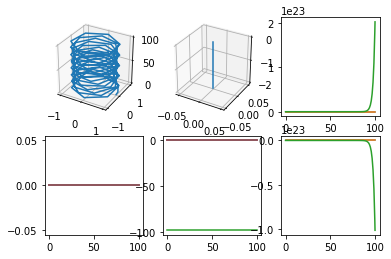

In [136]:
## write your code here
fig = plt.figure()
trajektoria = fig.add_subplot(231, projection='3d')
trajektoria.plot(xd,yd, zd)

zycie = fig.add_subplot(232, projection='3d')
zycie.plot(x,y, z)

bledy = fig.add_subplot(233)
bledy.plot(t,xd-x)
bledy.plot(t,yd-y)
#z ma downa
bledy.plot(t,zd-z)

ctrl1, ctrl2, ctrl3, ctrl4, ctrl5, ctrl6 =  MAT(ctrl).T[0]
kontrola = fig.add_subplot(234)
kontrola.plot(t, ctrl1)
kontrola.plot(t, ctrl2)
kontrola.plot(t, ctrl3)
kontrola.plot(t, ctrl4)
kontrola.plot(t, ctrl5)
kontrola.plot(t, ctrl6)

ext1, ext2, ext3, ext4, ext5, ext6 =  MAT(extf).T[0]
kontrola = fig.add_subplot(235)
kontrola.plot(t, ext1)
kontrola.plot(t, ext2)
kontrola.plot(t, ext3)
kontrola.plot(t, ext4)
kontrola.plot(t, ext5)
kontrola.plot(t, ext6)


predkosci = fig.add_subplot(236)
predkosci.plot(t, u)
predkosci.plot(t, v)
predkosci.plot(t, w)
####################

## Exercise 7:
Implement P, PD, and PID controllers independently for positional degrees of freedom for the task of trajectory tracking.